Semi-supervised learning.  
Predicting-future CAE network
Use 3d spatio-temporal conv kernels.  

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr#Pearson correlation coefficient
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import datetime
import time
#import winsound#sound alarm when code finishes, only in windows

from SemiNE3d.utils import *
from SemiNE3d.train import *

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible
#
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 100
#BATCH_SIZE = 1000 #100
#LR = 0.05#original
LR=2e-4 # 1e-4
L2=0.0#L2=0.000001#L2 regularization

In [3]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
#use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [4]:
training_inputs = np.load('../data/fig5_suppl_training_inputs.npy')
training_set = np.load('../data/fig5_suppl_training_set.npy')
test_inputs = np.load('../data/fig5_suppl_test_inputs.npy')
test_set = np.load('../data/fig5_suppl_test_set.npy')
movie_bgr_h5 = np.load('../data/fig5_suppl_movie_bgr_h5.npy')

In [5]:
#split original training data into two parts, training loader: 2200, validation loader: 200
#make the dataset suitable for pytorch and semi-supervised learning
train_loader=[]
for ii in range(30):
    #neural data
    temp0=training_inputs[ii*440:ii*440+440] -0.5 #center the stimulus
    temp1=training_set[ii*440:ii*440+440] #660
    #natural image data
    temp2=movie_bgr_h5[ii*1200:ii*1200+1200] 
    temp=(temp0,temp1,temp2)
    #temp=(temp0,temp1)
    train_loader.append(temp)
#
temp0=training_inputs[13200:] -0.5 #center the stimulus
temp1=training_set[13200:]#200*200(neurons)
temp2=movie_bgr_h5[36000:39200]
#val_loader=(temp0,temp1)
val_loader=(temp0,temp1,temp2)
#
temp0=np.copy(test_inputs) -0.5 #center the stimulus
temp1=np.copy(test_set)#50*200(neurons)
temp2=movie_bgr_h5[39200:]
#test_loader=(temp0,temp1)
test_loader=(temp0,temp1,temp2)
#
print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of train_loader[0][2]:')
print (train_loader[0][2].shape)
#
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of val_loader[2]:')
print (val_loader[2].shape)
#
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)
print ('shape of test_loader[2]:')
print (test_loader[2].shape)

length of train_loader:
30
shape of train_loader[0][0]:
(440, 2, 30, 28, 28)
shape of train_loader[0][1]:
(440, 64)
shape of train_loader[0][2]:
(1200, 2, 30, 28, 28)
shape of val_loader[0]:
(1200, 2, 30, 28, 28)
shape of val_loader[1]:
(1200, 64)
shape of val_loader[2]:
(3200, 2, 30, 28, 28)
shape of test_loader[0]:
(300, 2, 30, 28, 28)
shape of test_loader[1]:
(300, 64)
shape of test_loader[2]:
(800, 2, 30, 28, 28)


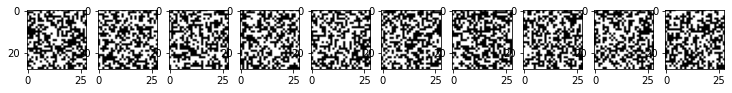

In [6]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(train_loader[0][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

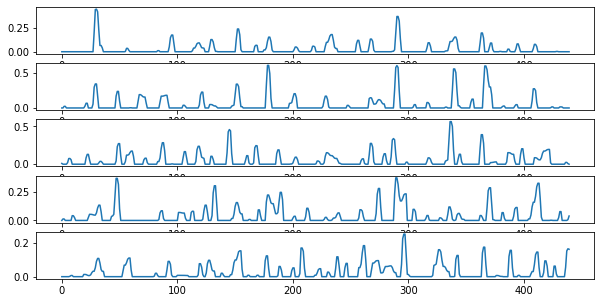

In [7]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(train_loader[0][1][:,ii])

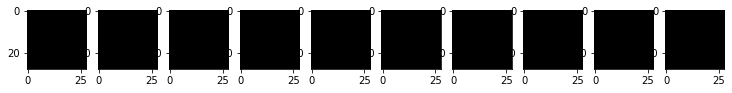

In [8]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(test_loader[0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

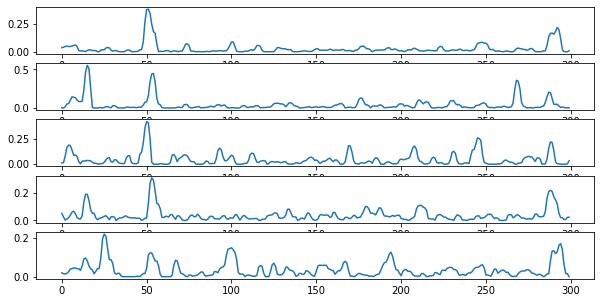

In [9]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(test_loader[1][:,ii])
    #axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [11]:
#preprocess: centered data
#sky_bg_mean_f   =(0.10539950580232095, 0.23792787064825932)
sky_bg_mean_f   =np.mean(movie_bgr_h5[:36000,:,:-2,:,:],axis=(0,2,3,4))/255.0
print(sky_bg_mean_f)

[0.19342407 0.20385705]


In [12]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle,save=False,filename=None): # conv3d_0.shape (16, 2, 8, 9, 9)
    (outd,_,_,_,_)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=3, ncols=outd,figsize=(outd, 3))
    for jj in range(outd):
        nt = conv3d_0.shape[2] # time lag
        ny = 9
        nx = 9
        dims = [nt, ny, nx]
        [sRF_UV, tRF_UV]=mySVD(conv3d_0[jj,0], dims)
        [sRF_G, tRF_G]=mySVD(conv3d_0[jj,1], dims)
        tempmax=np.max(np.abs([sRF_UV,sRF_G]))
        axes[0,jj].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[0,jj].set_xticks([])
        axes[0,jj].set_yticks([])
        axes[0,jj].set_title('%d' %(jj))
        axes[1,jj].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,jj].set_xticks([])
        axes[1,jj].set_yticks([])
        axes[2,jj].plot(tRF_G,color='g')
        axes[2,jj].plot(tRF_UV,color='purple')
        axes[2,jj].axhline(y=0,color='k')
        axes[2,jj].spines['left'].set_visible(False)
        axes[2,jj].spines['bottom'].set_visible(False)
        axes[2,jj].spines['right'].set_visible(False)
        axes[2,jj].spines['top'].set_visible(False)
        axes[2,jj].set_xticks([])
        axes[2,jj].set_yticks([])
        axes[0,0].set_ylabel(str(temptitle))
        axes[0,0].set_title('%d_UV' %(0))
    if save==True:
        fig.savefig(filename)

##  <font color='red'>Model architecture</font> 

In [13]:
class ModelSemiSL3d1_Conv3d_2(nn.Module):
    def __init__(self):
        super().__init__()
        #supervised
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=64 #number of neurons
        self.conv1=nn.Parameter(torch.zeros(self.numoffea,2,30,9,9))
        std=1. / np.sqrt(2*30*9*9)
        self.conv1.data.uniform_(-std, std)
        self.conv1_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_bias.data.uniform_(-std, std)
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #autoencoder
        #
        self.ae_dconv1 =nn.ConvTranspose2d(self.numoffea,2,kernel_size=9,stride=1,padding=4) #2,28*28
        self.ae_fc1    =nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_dfc1   = nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_encoder = nn.Sequential(
            #self.conv1, #16,28*28
            nn.ReLU(),
            Flatten3D(),
            self.ae_fc1,
            nn.ReLU(),
            #GaussianNoise(sigma=0)
        )
        self.ae_decoder = nn.Sequential(
            self.ae_dfc1,
            nn.ReLU(),
            Unflatten(-1,self.numoffea,28,28),
            self.ae_dconv1, #2,28*28
            nn.Tanh())
    #
    def forward(self, x, z):
        #supervised
        encoded = F.relu(F.conv3d(x, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,0,0))) #16,20*20
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        #autoencoder
        #z          = z.unsqueeze(2) 
        ae_encoded = F.conv3d(z, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,4,4))
        ae_encoded = self.ae_encoder(ae_encoded)
        ae_decoded = self.ae_decoder(ae_encoded)
        #ae_decoded = ae_decoded.squeeze(2) 
        return encoded, ae_encoded, ae_decoded
#for visualization of RFs
class ModelSemiSL3d1_Conv3d_2_copy(nn.Module):
    def __init__(self,conv1,conv1_bias,fc1_weight,fc1_bias):
        super().__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=64 #number of neurons
        self.conv1=nn.Parameter(torch.zeros(self.numoffea,2,30,9,9))
        std=1. / np.sqrt(2*30*9*9)
        self.conv1.data.uniform_(-std, std)
        self.conv1_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_bias.data.uniform_(-std, std)
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #
        self.conv1.data.copy_(conv1.clone().detach())
        self.conv1_bias.data.copy_(conv1_bias.clone().detach())
        self.fc1.weight.data.copy_(fc1_weight.clone().detach())
        self.fc1.bias.data.copy_(fc1_bias.clone().detach())
    #
    def forward(self, x):
        encoded = F.relu(F.conv3d(x, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,0,0))) #16,20*20
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded

##  <font color='red'>Different weights</font> 

In [ ]:
#Semi-supervised learning, ModelSemiSL2d1()
EPOCH=100
LR=3e-4 # 2e-4
alpha1s = [1e2] # [1e2]
alpha2s = [0] #not play a role
beta1s  =[1/16] # [1/4]
alpha3s =[1e3,  1e4,  1e5] # [1e3]
beta2s  =[1/64, 1/16, 1/4]
seeds   =[1]
lossweights=[0.8, 0.7, 0.6] # [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
modelvalloss=np.zeros((len(alpha3s), len(beta2s), len(lossweights)))
modeltestloss=np.zeros((len(alpha3s), len(beta2s), len(lossweights)))
for ii in range(len(alpha3s)):
    for jj in range(len(beta2s)):
        for kk in range(len(lossweights)):
            torch.manual_seed(seeds[0])    # reproducible
            torch.cuda.manual_seed(seeds[0])
            tempmodel = ModelSemiSL3d1_Conv3d_2()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            model_train(tempmodel,train_loader,optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[ii],beta2=beta2s[jj],lossweight=lossweights[kk],earlystop=True,verbose=True) 
            #torch.save(tempmodel.state_dict(),\
            #       './out/20200219_v5_ModelSemiSL3d1_Conv3d_2_upandlow_seed_'+seedname+'_weight_'+modelname+'.pth')
        
            temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
            print ('Val CC: {}'.format(temp))
            modelvalloss[ii,jj,kk]=temp
            temp,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
            #print (temp)
            modeltestloss[ii,jj,kk]=temp
            del tempmodel
            torch.cuda.empty_cache()

2021-05-20 09:46:19.244365
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  0 | train loss: 0.8325
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  1 | train loss: 0.1998
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  2 | train loss: 0.1815
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  3 | train loss: 0.1810
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  4 | train loss: 0.1804
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  5 | train loss: 0.1797
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  6 | train loss: 0.1791
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  7 | train loss: 0.1786
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  8 | train loss: 0.1782
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  9 | train loss: 0.1778
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  10 | train loss: 0.1774
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  11 | train loss: 0.1769
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  12 | train loss: 0.1766
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  13 | train loss: 0.1762
Model:  ModelSemiSL3d1_Conv3d_2 |Epoch:  14 | train loss: 0.1759


In [19]:
'''
alpha3s =[1e3,  1e4,  1e5] 
beta2s  =[1/64, 1/16, 1/4]
seeds   =[1]
lossweights=[0.8, 0.7, 0.6]
'''
print (np.max(modelvalloss))
print (np.argmax(modelvalloss))
print (modelvalloss)
print (np.max(modeltestloss))
print (np.argmax(modeltestloss))
print (modeltestloss)

0.29443663966859246
16
[[[0.26917857 0.26596688 0.26383634]
  [0.27537389 0.27664341 0.27364061]
  [0.27342647 0.27678307 0.27812685]]

 [[0.28739128 0.28941075 0.29008651]
  [0.28792205 0.2936086  0.22337031]
  [0.28663815 0.29443664 0.21603213]]

 [[0.21517267 0.21515271 0.21514571]
  [0.21560216 0.21507152 0.21466444]
  [0.21541527 0.21513308 0.21540303]]]
0.5253796538170545
16
[[[0.4837586  0.47138335 0.46610707]
  [0.49540994 0.50579091 0.49070607]
  [0.48841532 0.49079429 0.49024594]]

 [[0.51531861 0.51922978 0.51364023]
  [0.51689499 0.52477546 0.36820277]
  [0.51200876 0.52537965 0.34486903]]

 [[0.3396425  0.3399524  0.33870582]
  [0.34021673 0.33836631 0.33738106]
  [0.33968701 0.34039065 0.33932705]]]


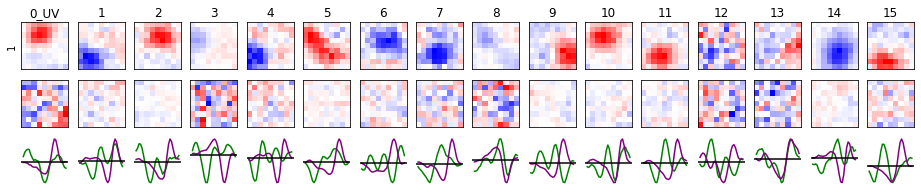

In [20]:
modelname=[3] # np.arange(1,10) #np.arange(1,3) [1,3,5,7]
plt.rcParams.update({'figure.max_open_warning': 0})
temptitle=1
for ii in range(len(modelname)):
    #print (ii)
    #print ('\n')
    #load model
    tempmodel= ModelSemiSL3d1_Conv3d_2()
    tempmodel.load_state_dict(torch.load\
                ('./out/20200219_v5_ModelSemiSL3d1_Conv3d_2_upandlow_seed_1_weight_'+str(modelname[ii])+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    #get parameters of model
    #conv3d_0=tempmodel.encoder[0].weight.cpu().data.numpy()
    conv3d_0=tempmodel.conv1.cpu().data.numpy()
    
    Vis_conv3d_0(conv3d_0,temptitle,save=False,\
        filename='out_result/20200219_v5_ModelSemiSL3d1_Conv3d_2_upandlow_weight_3_conv0_v5.svg')
    temptitle=temptitle+1
    torch.cuda.empty_cache()

##  <font color='red'>after hyperparameter tuning</font> 

In [ ]:
#Semi-supervised learning, ModelSemiSL2d1()
EPOCH=100
LR=3e-4 # 2e-4
alpha1s = [1e2] 
alpha2s = [0] #not play a role
beta1s  =[1/16] 
alpha3s =[1e4] 
beta2s  =[1/4]
seeds   = [1]
lossweights=[0.9, 0.8, 0.7, 0.6, 0.5]
modelvalloss=[]
for ii in range(len(seeds)):
    for jj in range(len(lossweights)):
        seedname=str(ii+1) #start from first seed
        modelname=str(jj+1) # modelname=1 and 9
        torch.manual_seed(seeds[ii])    
        torch.cuda.manual_seed(seeds[ii])
        tempmodel = ModelSemiSL3d1_Conv3d_2()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        model_train(tempmodel,train_loader,optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                alpha1=alpha1s[0],alpha2=alpha2s[0],\
                beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=False) 
        torch.save(tempmodel.state_dict(),\
               './out/20200219_v5_ModelSemiSL3d1_Conv3d_2_upandlow_seed_'+seedname+'_weight_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
        modelvalloss.append(temp)
        del tempmodel
        torch.cuda.empty_cache()

2021-05-22 10:46:42.161103
Epoch: 55 val loss: 0.2790, finish training!
2021-05-22 11:21:35.155528
2021-05-22 11:21:49.644763


(64, 2, 30, 28, 28)


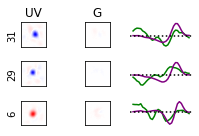

In [18]:
# save svd results of example neuronal RFs
nt = 30 # time lag
ny = 28
nx = 28
dims = [nt, ny, nx]
#
#visualize final layer of model
tempmodel= ModelSemiSL3d1_Conv3d_2()
tempmodel.load_state_dict(torch.load('./out/20200219_v5_ModelSemiSL3d1_Conv3d_2_upandlow_seed_1_weight_3'+'.pth'))
tempmodel=tempmodel.to(device_cpu)
conv1  =tempmodel.conv1.data.clone().detach()
conv1_bias   =tempmodel.conv1_bias.data.clone().detach()
fc1_weight=tempmodel.fc1.weight.data.clone().detach()
fc1_bias  =tempmodel.fc1.bias.data.clone().detach()
tempmodel= ModelSemiSL3d1_Conv3d_2_copy(conv1,conv1_bias,fc1_weight,fc1_bias)
tempmodel=tempmodel.to(device_cpu)
RF_fl=vis_model_fl_3d(tempmodel,device_cpu,(1,2,nt,28,28))
RF_fl_np=RF_fl.cpu().data.numpy() #output shape (50,2,28,28)
print (RF_fl_np.shape)
#nums_eg=np.arange(len(RF_fl_np))
#
#plot RFs
nums_eg=[31,29,6]  # [31,29,55], [1,2,6]
nrows=len(nums_eg)
fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(3,int(nrows/1.1)))
for ii in range(nrows):
    [sRF_UV, tRF_UV]=mySVD(RF_fl_np[nums_eg[ii],0], dims)
    [sRF_G, tRF_G]=mySVD(RF_fl_np[nums_eg[ii],1], dims)
    tempmax=np.max(np.abs([sRF_UV,sRF_G]))
    axes[ii,0].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,0].set_xticks([])
    axes[ii,0].set_yticks([])
    axes[ii,0].set_ylabel('%d' %(nums_eg[ii]))
    axes[ii,1].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,1].set_xticks([])
    axes[ii,1].set_yticks([])
    axes[ii,2].plot(tRF_G,color='g',linestyle='-')
    axes[ii,2].plot(tRF_UV,color='purple',linestyle='-')
    axes[ii,2].axhline(y=0,color='k',linestyle=':')
    axes[ii,2].spines['left'].set_visible(False)
    axes[ii,2].spines['bottom'].set_visible(False)
    axes[ii,2].spines['right'].set_visible(False)
    axes[ii,2].spines['top'].set_visible(False)
    axes[ii,2].set_xticks([])
    axes[ii,2].set_yticks([])
axes[0,0].set_title('UV')
axes[0,1].set_title('G')
plt.tight_layout()
#plt.savefig("out_result/20200219_v5_ModelSemiSL3d1_Conv3d_2_upandlow_RFs.svg")

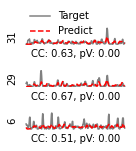

In [19]:
#plot prediction results for example neurons
tempmodel= ModelSemiSL3d1_Conv3d_2()
tempmodel.load_state_dict(torch.load('./out/20200219_v5_ModelSemiSL3d1_Conv3d_2_upandlow_seed_1_weight_3'+'.pth'))
tempmodel=tempmodel.to(device_cpu)
tempmodel=tempmodel.eval()
(x,y,z)=test_loader
x=torch.from_numpy(x).float()
b_x = x.to(device_cpu)
z=z/255.0
z[:,0,:,:,:]=z[:,0,:,:,:]-sky_bg_mean_f[0]
z[:,1,:,:,:]=z[:,1,:,:,:]-sky_bg_mean_f[1]
if 'Conv3d_1' in tempmodel.__class__.__name__:
    #b_z = torch.from_numpy(z).float().to(device)
    b_z = torch.from_numpy(z[:,:,:-1,:,:]).float().to(device_cpu)
elif 'Conv3d_2' in tempmodel.__class__.__name__:
    #b_z = torch.from_numpy(z).float().to(device)
    #b_z[:,:,-1,:,:]=0 # 7th frame is set to 0 after preprocessing
    b_z = torch.from_numpy(z[:,:,:-1,:,:]).float().to(device_cpu)
    b_z[:,:,-1,:,:]=0 # the last frame is set to 0 after preprocessing
elif 'Conv3d_4' in tempmodel.__class__.__name__:
    b_z = torch.from_numpy(z[:,:,:z.shape[2]-1,:,:]).float().to(device_cpu)  

with torch.no_grad():
    encoded,_,_ = tempmodel(b_x,b_z)
encoded_np=encoded.cpu().data.numpy()
encoded_np=encoded_np[7:,:] #use_pad0_sti=False
y=y[7:,:] #use_pad0_sti=False
#
nums_eg=[31,29,6]  # [31,29,55], [1,2,6]
nrows=len(nums_eg)
#nrows=encoded_np.shape[1]
testccs=np.zeros((nrows))
testpVs=np.zeros((nrows))
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(2,int(nrows/1.1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,nums_eg[ii]], y[:,nums_eg[ii]])
    testccs[ii]=testcc
    testpVs[ii]=testpvalue
    axes[ii].plot(y[:,nums_eg[ii]],color='gray',linestyle='-',label='Target')
    axes[ii].plot(encoded_np[:,nums_eg[ii]],color='red',linestyle='--',label='Predict')
    if ii == 0:
        axes[ii].legend(loc='best',frameon=False)
        #axes[ii].set_title('UVGnoise_30Hz')
    #axes[ii].set_title('Neuron: {:}, CC: {:.2f}, p: {:.2f}'.format(ii,testcc,testpvalue))
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(nums_eg[ii]))
plt.tight_layout()
#fig.savefig('out_result/20200219_v5_ModelSemiSL3d1_Conv3d_2_upandlow_CCs.svg')